In [1]:
import numpy as np
import matplotlib.pyplot as plt
import book_plots

In [2]:
from numpy.random import randn
def gen_data(x0, dx, count, noise_factor):
    return [x0 + dx*i + randn()*noise_factor for i in range(count)]

In [3]:
def plot_g_h_results (measurements, filtered_data, title=''):
    plt.plot (filtered_data, '--',label='filter')
    plt.plot(measurements,label='measurement')
    plt.legend(loc=4)
    plt.title(title)
    plt.show()

## Structure

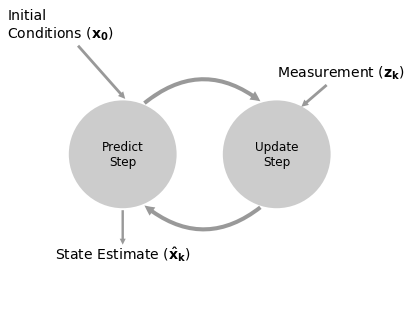

In [4]:
book_plots.predict_update_chart()

We can express this as an algorithm:

**Initialization**

1. Initialize the state of the filter
2. Initialize our belief in the state

**Predict**

1. Use system behavior to predict state at the next time step
2. Adjust belief to account for the uncertainty in prediction

**Update**

1. Get a measurement and associated belief about its accuracy
2. Compute residual between estimated state and measurement
3. New estimate is somewhere on the residual line

We will use this same algorithm throughout the book, albeit with some modifications.

\begin{align}
{x_p}\left( k \right) = {x_s}\left( {k - 1} \right) + \Delta x\left( {k - 1} \right) \cdot \Delta T \\
\Delta x\left( k \right) = \Delta x\left( {k - 1} \right) \\
res = {x_o}\left( k \right) - {x_p}\left( k \right)  \\
{x_s}\left( k \right) = {x_p}\left( k \right) + g \cdot res \\
\Delta x\left( k \right) = \Delta x\left( k \right) + h \cdot \left( {\frac{{res}}{{\Delta T}}} \right)
\end{align}

In [5]:
weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

### Part 1.  Performs g-h filter on 1 state variable with a fixed $g$ and $h$.

In [6]:
def g_h_filter (data, x0, dx, g, h, dt=1., pred=None):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.

    'data' contains the data to be filtered.
    'x0' is the initial value for our state variable
    'dx' is the initial change rate for our state variable
    'g' is the g-h's g scale factor
    'h' is the g-h's h scale factor
    'dt' is the length of the time step 
    'pred' is an optional list. If provided, each prediction will be stored in it
    """
    x_est = x0
    results = []
    for z in data:
        # prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
    return np.array(results)

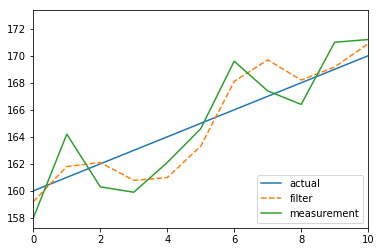

In [7]:
plt.xlim([0,10])
plt.plot([0,10],[160,170],label='actual')
data = g_h_filter (data=weights, x0=160, dx=1, g=6./10, h = 2./3, dt=1.)
plot_g_h_results (weights, data)

### Part 2. Discussion 

#### Case 1. Bad Initial Conditions

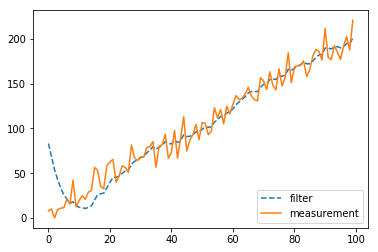

In [8]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=10)
data = g_h_filter(data=zs, x0=100., dx=2., dt=1., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

#### Case 2. Extreme Noise
Noise factor of 100

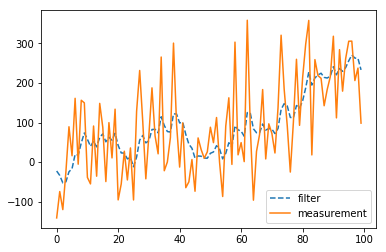

In [9]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=2., dt=1., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

This doesn't look so wonderful to me. We can see that perhaps the filtered signal varies less than the noisy signal, but it is far from the straight line.

#### Case 3. The Effect of Acceleration 

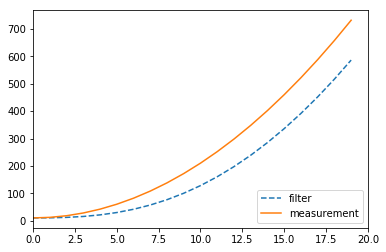

In [10]:
def gen_data(x0, dx, count, noise_factor, accel=0.):
    zs = []
    for i in range(count):
        zs.append(x0 + dx*i + randn()*noise_factor)
        dx += accel
    return zs
   
predictions = []
zs = gen_data(x0=10., dx=0., count=20, noise_factor=0, accel=2.)
data = g_h_filter(data=zs, x0=10., dx=0., g=0.2, h=0.02)
plt.xlim([0, 20])
plot_g_h_results(measurements=zs, filtered_data=data)

Each prediction lags behind the signal. If you think about what is happening this makes sense. Our model assumes that velocity is constant. The g-h filter computes the first derivative of $x$ (we use $\dot{x}$ to denote the derivative) but not the second derivative $\ddot{x}$. So we are assuming that $\ddot{x}=0$. At each prediction step we predict the new value of x as $x + \dot{x}*t$. But because of the acceleration the prediction must necessarily fall behind the actual value. We then try to compute a new value for $\dot{x}$, but because of the $h$ factor we only partially adjust $\dot{x}$ to the new velocity. On the next iteration we will again fall short.

### Part 3. Impact of g and h

#### Varying $g$ Case 1:
Recall that $g$ is the scale factor for choosing between the measurement and prediction.

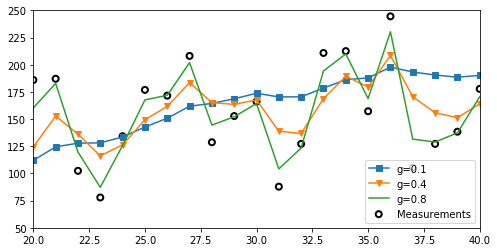

In [11]:
np.random.seed(100)
zs = gen_data(x0=5., dx=5., count=50, noise_factor=50)
data1 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.4, h=0.01)
data3 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.8, h=0.01)
with book_plots.figsize(y=4):
    book_plots.plot_measurements(zs, color='k')
    book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
    book_plots.plot_filter(data2, label='g=0.4', marker='v', c='C1')
    book_plots.plot_filter(data3, label='g=0.8', c='C2')
    plt.legend(loc=4)
    book_plots.set_limits([20, 40], [50, 250])

It is clear that as $g$ is larger we more closely follow the measurement instead of the prediction. 

#### Varying $g$ Case 2:
What happens when the signal changes not due to noise, but an actual state change?

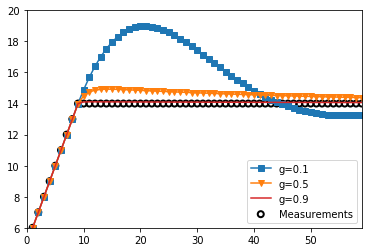

In [12]:
zs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for i in range(50):
    zs.append(14)

data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.5, h=0.01)
data3 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.9, h=0.01)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
book_plots.plot_filter(data2, label='g=0.5', marker='v', c='C1')
book_plots.plot_filter(data3, label='g=0.9', c='C3')
plt.legend(loc=4)
plt.ylim([6, 20]);

Here we can see the effects of ignoring the signal. We not only filter out noise, but legitimate changes in the signal as well.

#### Varying $h$
$h$ affects how much we favor the measurement of $\dot{x}$ vs our prediction. 
But what does this mean? 
* If our signal is changing a lot (quickly relative to the time step of our filter), then a large $h$ will cause us to react to those transient changes rapidly. 
* A smaller $h$ will cause us to react more slowly.

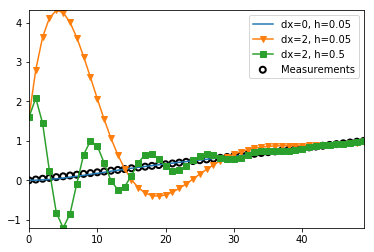

In [13]:
zs = np.linspace(0, 1, 50)

data1 = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05)
data2 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05)
data3 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='dx=0, h=0.05', c='C0')
book_plots.plot_filter(data2, label='dx=2, h=0.05', marker='v', c='C1')
book_plots.plot_filter(data3, label='dx=2, h=0.5',  marker='s', c='C2')
plt.legend(loc=1);

In [14]:
from ipywidgets import interact, FloatSlider

zs1 = gen_data(x0=5, dx=5., count=100, noise_factor=50)

fig = None
def interactive_gh(x, dx, g, h):
    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure()
    data = g_h_filter(data=zs1, x0=x, dx=dx, g=g, h=h)
    plt.scatter(range(len(zs1)), zs1, edgecolor='k', 
                facecolors='none', marker='o', lw=1)
    plt.plot(data, color='b')

interact(interactive_gh,           
         x=FloatSlider(value=0., min=-200, max=200., continuous_update=False), 
         dx=FloatSlider(value=5., min=-50., max=50., continuous_update=False), 
         g=FloatSlider(value=0.1, min=0.01, max=2, step=.02, continuous_update=False), 
         h=FloatSlider(value=0.02, min=0.0, max=0.5, step=0.01, continuous_update=False));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=200.0, min=-200.0), FloatSlider(value=5.0, continuous_update=False, description='dx', max=50.0, min=-50.0), FloatSlider(value=0.1, continuous_update=False, description='g', max=2.0, min=0.01, step=0.02), FloatSlider(value=0.02, continuous_update=False, description='h', max=0.5, step=0.01), Output()), _dom_classes=('widget-interact',))